
#Assignment Set 8

by **Amir Mehrpanah** for Deep Learing Course at Data Science Center, SBU



In [5]:
#@title Manual Data Injection
from six.moves import cPickle as pickle
import platform
import numpy as np
 
def load_files(filenames):
    data = np.array([])
    labels = np.array([])
    for name in filenames:
        with open(name, 'rb') as f:
            mydict = pickle.load(f, encoding='latin1')

        # The labels have different names in the two datasets.
        label_func = lambda x: np.array(x['fine_labels'], dtype='int32')
        newlabels = label_func(mydict)
        if data.size:
            data = np.vstack([data, mydict['data']])
            labels = np.hstack([labels, newlabels])
        else:
            data = mydict['data']
            labels = newlabels
    data = np.reshape(data, [-1, 3, 32, 32], order='C')
    data = np.transpose(data, [0, 2, 3, 1])

    return data, labels

def load_CIFAR100(data_dir):
    """ load all of cifar """
    train_files = ['train']
    train_files = [os.path.join(data_dir, f) for f in train_files]
    test_files = ['test']
    test_files = [os.path.join(data_dir, f) for f in test_files]
    num_classes = 100
    train_data, train_labels = load_files(train_files)
    test_data, test_labels = load_files(test_files)

    return train_data, train_labels, test_data, test_labels
 
def get_CIFAR100_data(val_size=5000):
    # Load the raw CIFAR-100 data
    cifar100_dir = 'data/cifar/cifar-100-python/'
    x_train, y_train, x_test, y_test = load_CIFAR100(cifar100_dir)
    # Subsample the data
 
    x_train, x_val = np.split(x_train,
                              [x_train.shape[0]-val_size])
    y_train, y_val = np.split(y_train,
                              [y_train.shape[0]-val_size])
    
    x_train = x_train.astype('float32')
    x_val = x_val.astype('float32')
    x_test = x_test.astype('float32')
    
    std = StandardScaler()
    shape = x_train.shape
    x_train = std.fit_transform(x_train.reshape(-1,3072)).reshape(shape)
    shape = x_val.shape
    x_val = std.transform(x_val.reshape(-1,3072)).reshape(shape)
    shape = x_test.shape
    x_test = std.transform(x_test.reshape(-1,3072)).reshape(shape)

    return x_train, y_train, x_val, y_val, x_test, y_test
 
# Invoke the above function to get our data.
x_train, y_train, x_val, y_val, x_test, y_test = get_CIFAR100_data()
 
print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', x_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (45000, 32, 32, 3)
Train labels shape:  (45000,)
Validation data shape:  (5000, 32, 32, 3)
Validation labels shape:  (5000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Model Without Data Augmentation

## Model With Data Augmentation

In [ ]:
#@title Convolutional NN Tensorflow
#@markdown Training a convolutional neural network to compare the performance
# with open('history.pkl', 'rb') as f:
#         mdl_pool = pickle.load(f)
mdl_pool = {}
for item in 'Adam','RMSprop','Adadelta','SGD':
    name = 'conv_clf_l2_'+item
    
    x = input = keras.Input(shape=(32,32,3))
    x = layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")(input)
    x = layers.experimental.preprocessing.RandomContrast(0.2)(x)
    x = layers.experimental.preprocessing.RandomRotation(3)(x)
    x = layers.Conv2D(64,4,activation='relu')(x)
    x = layers.Conv2D(64,4,activation='relu',kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.MaxPool2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128,3,activation='relu')(x)
    x = layers.Conv2D(128,3,activation='relu',kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256,3,activation='relu')(x)
    x = layers.Conv2D(256,3,activation='relu',kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512,activation='relu',kernel_regularizer=regularizers.l2(1e-5))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256,activation='relu',kernel_regularizer=regularizers.l2(1e-5))(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128,activation='relu',kernel_regularizer=regularizers.l2(1e-5))(x)
    output = layers.Dense(100,'softmax')(x)

    model = keras.Model(inputs=input, outputs=output, name=name)
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                optimizer=item,
                metrics=['accuracy'])

    mdl_pool[name] = model.fit(x = x_train, y = y_train,
                    batch_size=128, epochs=200,
                    verbose=2,validation_data=(x_val,y_val),
                    validation_batch_size = 128).history
    with open('history.pkl', 'wb') as f:
        pickle.dump(mdl_pool, f)

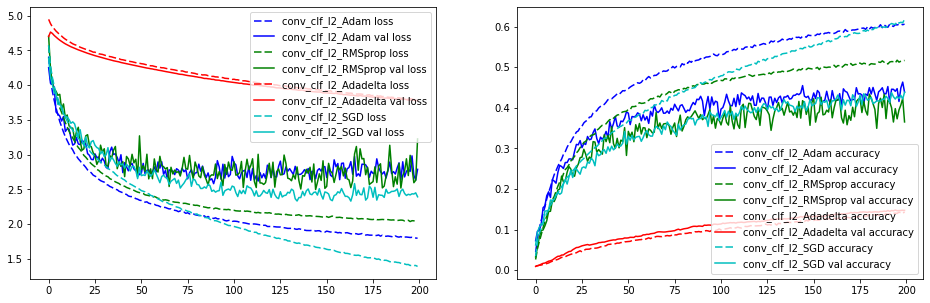

In [17]:
#@title Plot Training History
plt.figure(figsize=(16,5))
c = ['b', 'g', 'r', 'c']
plt.subplot(121)
for i,(name,item) in enumerate(mdl_pool.items()):
    plt.plot(item['loss'],linestyle=(0,(5,2)),color=c[i],label = name+' loss')
    plt.plot(item['val_loss'],color=c[i],label = name+' val loss')
plt.legend()

plt.subplot(122)
for i,(name,item) in enumerate(mdl_pool.items()):
    plt.plot(item['accuracy'],linestyle=(0,(5,2)),color=c[i],label = name +' accuracy')
    plt.plot(item['val_accuracy'],color=c[i],label = name+' val accuracy')
plt.legend()